<h2>Development</h2>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils,array_to_img,img_to_array,load_img
import tensorflow as tf

from IPython import display
from IPython.core.display import HTML

from PIL import Image
from io import BytesIO
import base64
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import plotly.express as px

#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [43]:
# Loading a picture in the dataset
main_folder = 'DataSources/CelebFacesAttributesDataset/'
images_folder = main_folder + 'img_align_celeba/img_align_celeba/'

picture = images_folder+'000007.jpg'

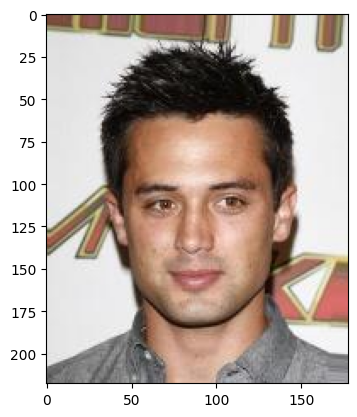

In [44]:
# Displaying one of the picture in the dataset
img = mpimg.imread( picture )
imgplot = plt.imshow( img )
plt.show()

In [45]:
# Loading dataset containing different attributes for each image 
df = pd.read_csv(main_folder+'list_attr_celeba.csv')
df

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,-1,1,-1,1,1,-1,1,-1,-1,1


As is common in many machine learning projects here on Kaggle, I will replace the -1 values with 0 to indicate the absence of features in each image. I will also set the Id column as the index and plot a list of column names in the dataframe for better clarity.

In [46]:
df.set_index('image_id', inplace = True) # Setting 'image_id' column as Index
df.replace(to_replace = -1, value = 0,inplace = True ) # Replacing '-1' values for '0', indicating the absence of attributes in the image
df.head(10) # Displaying dataframe after changes 

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
000006.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,1,1,0,1,0,0,1
000007.jpg,1,0,1,1,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,0,1
000008.jpg,1,1,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
000009.jpg,0,1,1,0,0,1,1,0,0,0,...,0,1,0,0,1,0,1,0,0,1


The output cell above makes it easier to observe a multitude of features contained within this dataset, such as the presence of a goatee, beard, or wavy hair. One particular column that stands out is 'Male', which may serve as an indicator for training a model that aims to identify the gender of a person based on the images provided as input. To gain a deeper understanding of this column, I will create a new dataframe that only includes the 'Male' column.

In [47]:
# Creating 'gender' dataframe
gender = df[['Male']]
gender.head(10)

,Male
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,1
000004.jpg,0
000005.jpg,0
000006.jpg,0
000007.jpg,1
000008.jpg,1
000009.jpg,0


It's possible to see that picture above is correctly labeled as 1, indicating the presence of a male face in the image.<br><br>
We can see that image <i>000009.jpg</i> is labeled as 0, which indicates the absence of a male face and presence of a female face. Let's plot the image on the next code cell to see if that label is correct.

It can be observed that the image in question indeed contains a female face, and it is correctly labeled as 0.<br><br> 
Now that we have a clear understanding of the structure of the dataset, we can proceed to plot a pie chart to showcase the distribution of labels within the dataset.

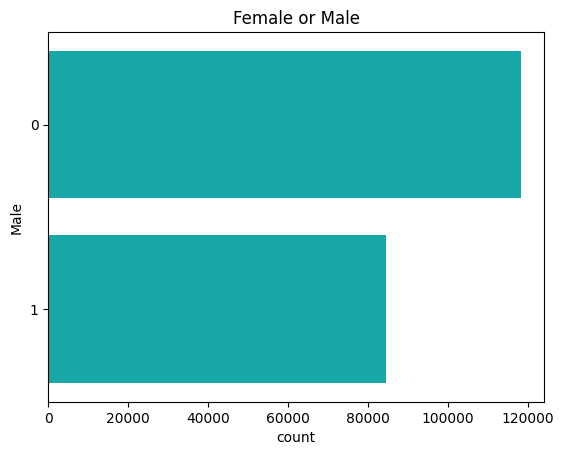

In [48]:
# Plotting gender distribution pie plot
labels = {1:'Male', 0:'Female'} # Assigning 'Male' value for 1 and 'Female' value for 0
value_counts = gender['Male'].value_counts()
values = pd.DataFrame({'Male': value_counts.index, 'count': value_counts.values})
values['Male'] = values['Male'].map(labels)
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df, color="c")
plt.show()

The majority of images within the dataset depict female faces, approximately 58.3%, while the remaining 41.7% depict male faces.<br><br>
In general, a 58.3% / 41.7% distribution is considered moderately imbalanced, and it may not cause major issues in the training process, although it can cause the model to get a bit biased towards the class with more data.

Next, we load the partition dataframe that separates the dataset into training, validation, and testing sets, based on their respective partition labels.

In [49]:
# Loading and displayin partitions dataframe
partitions_df = pd.read_csv(main_folder+'list_eval_partition.csv')
partitions_df

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,2
202595,202596.jpg,2
202596,202597.jpg,2
202597,202598.jpg,2


It's important to understand the distribution of the dataset across the three different sets for training, validation, and testing. To do so, I will create a new dataframe that showcases the value counts for each partition label along with its corresponding distribution percentage. This information will give us a better understanding of the proportion of data that is allocated to each set and its significance in the overall model training process.

In [50]:
# Displaying partition distribution
# 0 ==> Training
# 1 ==> Validation
# 2 ==> Testing
partitions_counts = partitions_df['partition'].value_counts()
partitions_percentages = (partitions_df['partition'].value_counts(normalize=True) * 100).round(2)

partitions_values = pd.DataFrame({'count': partitions_counts, 'percentage':partitions_percentages})
partitions_values['percentage'] = partitions_values['percentage'].astype(str) + '%'

partitions_values.index = partitions_values.index.rename('partition')
partitions_values.index = partitions_values.index.map({0: 'Training',
                                                      1: 'Validation',
                                                      2: 'Testing'})
partitions_values

,count,percentage
partition,,
Training,162770,80.34%
Testing,19962,9.85%
Validation,19867,9.81%


The majority of the images, 80.34%, are designated for training the model, while 9.85% and 9.81% of them are allocated for the testing and validation sets, respectively. This distribution allows for a balanced distribution of images for training and evaluating how well the model performs.

In [59]:
# Setting index for 'partitions_df'
partitions_df.set_index('image_id', inplace = True)
partitions_df

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0
...,...
202595.jpg,2
202596.jpg,2
202597.jpg,2


In order to prepare the data for the training and evaluation process, I will merge both the <i>partitions_df</i> and <i>gender</i> dataframes into a single one by their indexes. This new dataframe will provide all necessary information required to train and evaluate the model.

In [64]:
# Merging dataframes
data = gender.merge(partitions_df['partition'], left_index = True, right_index = True)
data

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0
...,...,...
202595.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2


In order to optimize the memory usage, we will now proceed to the reduction of the size for each training and evaluation set by specifying smaller partitions. This will enable us to effectively train and evaluate our model while avoiding memory limitations.

In [12]:
TRAINING_SAMPLES = 10000 # Defining the amount of samples for the training set
VALIDATION_SAMPLES = 2000 # Defining the amount of samples for the validation set
TEST_SAMPLES = 2000 # Defining the amount of samples for the testing set
IMG_WIDTH = 178 # Setting image width
IMG_HEIGHT = 218 # Setting image height

The next step is to create two functions, one to load and preprocess individual image files, and another to generate the training, validation, and testing sets based on the partition labels. The first function takes the file name as input and loads the image, converts it to an array and normalizes the pixel values by dividing it by 255. The second function uses the partition, attribute and number of samples parameters to separate the data into different sets, returning the processed image data and the corresponding target attributes.

In [72]:
# Loading Images
def load_reshape_img(fname):
    img = load_img(fname) # Loading image 
    x = img_to_array(img)/255. # Converting to array and normalizing
    x = x.reshape((1,) + x.shape) # Reshaping array to have an extra dimension of size 1

    return x


# Generating datasets
def sets_generator(partition, attribute, num_samples):
    
    # Creating 'df_' dataframe, consisting of an equal number of samples for male and female images
    # by selecting half of the samples with a value of 0 and half with a value of 1 from 'data' dataframe
    df_ = data[(data['partition'] == partition)].sample(int(num_samples))
    # df_ = pd.concat([df_,
    #                   data[(data['partition'] == partition) 
    #                               & (data[attribute] == 1)].sample(int(num_samples/2))])
    
    
    #df_ = data
    # For the training and validation sets
    if partition != 2:
        
        # Loading images and storing them in the 'x_' array
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        
        # Storing target variable in the 'y_' array
        y_ = np_utils.to_categorical(df_[attribute],2) # Converting binary attributes to categorical variables
        
    # For the testing set
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            
            # Taking images as input and resizing
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im) # Storing in normalized images
            y_.append(target[attribute]) # Storing in the target variable

    return x_, y_

Now we can proceed to divide the data into different sets and apply data augmentation techniques to enhance the variability of the data.

In [73]:
# Splitting data
X_train, y_train = sets_generator(0, 'Male', TRAINING_SAMPLES)

In [74]:
# Splitting data
X_val, y_val = sets_generator(1, 'Male', VALIDATION_SAMPLES)

<h2>Modeling</h2>

In [75]:
# Loading InceptionV3

base_model = InceptionV3(weights='DataSources/InceptionV3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)


# Freezing layers in the base model to prevent overfitting
for layer in base_model.layers:
    layer.trainable = False
    
# Adding new layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
predictions = Dense(2, activation = 'softmax')(x)
# Defining final model
model = Model(inputs = base_model.input, outputs = predictions)

In [76]:
# Compiling model created above
model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [18]:
# ModelCheckpoint is used to save the best model 
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.nodata.hdf5', 
                               verbose=1, save_best_only=True)

In [77]:
# Training model
history = model.fit(X_train, y_train,
         validation_data = (X_val, y_val), epochs = 10, batch_size = 32, callbacks=[checkpointer])

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8901
Epoch 1: val_loss did not improve from 0.14895
313/313 [==============================] - 1455s 5s/step - loss: 0.3088 - accuracy: 0.8901 - val_loss: 0.1766 - val_accuracy: 0.9300
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.1999 - accuracy: 0.9173
Epoch 2: val_loss did not improve from 0.14895
313/313 [==============================] - 1447s 5s/step - loss: 0.1999 - accuracy: 0.9173 - val_loss: 0.1929 - val_accuracy: 0.9230
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.1844 - accuracy: 0.9243
Epoch 3: val_loss did not improve from 0.14895
313/313 [==============================] - 1433s 5s/step - loss: 0.1844 - accuracy: 0.9243 - val_loss: 0.1793 - val_accuracy: 0.9300
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9286
Epoch 4: val_loss did not improve from 0.14895
313/313 [====================

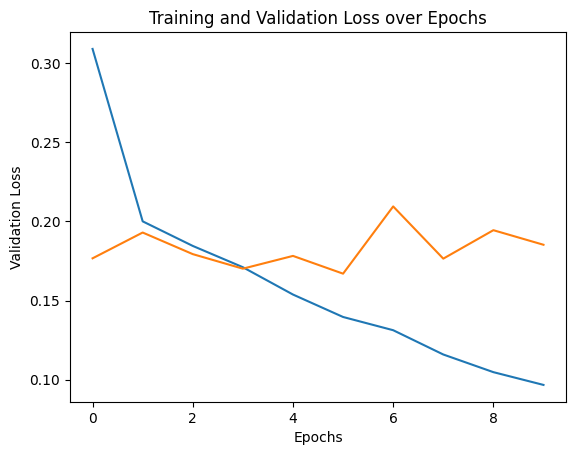

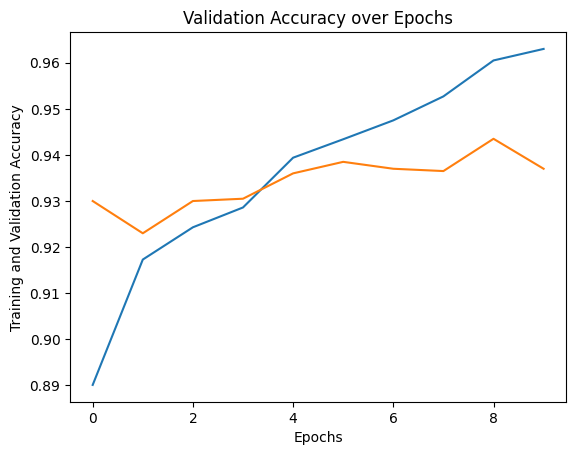

In [78]:
# Plotting loss function and accuracy over epochs
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

plt.plot(range(len(train_loss)), train_loss, label = 'Training Loss')
plt.plot(range(len(val_loss)), val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.show()

plt.plot(range(len(train_acc)), train_acc, label = 'Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.show()

The model was trained for 10 epochs.Each epoch is a complete iteration over the entire training dataset. <br><br>

The loss function, binary crossentropy, and the accuracy metric are both used to evaluate model's performance. The model's training accuracy improves over each epoch, with the accuracy increasing from 0.88 to 0.96. The validation loss decreased from 0.27 to 0.20 over the same period.<br><br>

The model is performing well, achieving an accuracy of 0.93 on the validation set after 10 epochs. The training and validation loss decreased over each epoch, which is a sign that the model learned from the data. The best validation loss of 0.15811 was achieved in the 4th epoch, and the model's weights were saved during that epoch thanks to the ModelCheckpoint function.<br><br>

We can now use this model to make predictions on the testing set.

In [79]:
# Loading best model
model.load_weights('weights.best.inc.male.nodata.hdf5')

In [80]:
# Splitting testing data
X_test, y_test = sets_generator(2, 'Male', TEST_SAMPLES)

In [81]:
# Running predictions on testing data
from sklearn.metrics import accuracy_score
y_pred = [np.argmax(model.predict(feature)) for feature in X_test ]
acc = (accuracy_score(y_test, y_pred)) * 100

1/1 [==============================] - 0s 252ms/step


In [82]:
# Printing accuracy on testing data
print(f"Accuracy: %.2f%%" % acc)

Accuracy: 91.95%


Based on the 91.85% accuracy score achieved on the testing set, we can conclude that the model is performing well in detecting people's genders based on facial features.<br><br>
This high accuracy score indicates that the model has successfully learned the patterns in the training data and is able to generalize well to new, unseen data.

In [117]:
import sys
sys.path.append('D:/UH_Computer Science/4to/Machine Learning/Proyecto Final Sesgos/bias-project-ML')

from metrics import*

In [118]:
print(macro_accuracy(y_test, y_pred))

0.922595785837211


In [119]:
MALE=1
FEMALE= 0
GENDER_LABELS=[FEMALE, MALE]

In [120]:

print(macro_f1(y_test,y_pred,GENDER_LABELS))

0.9158046448119581


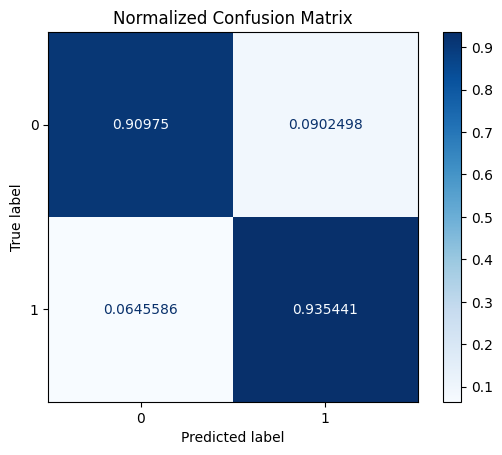

In [121]:
confusion_matrix= confusion_matrix(y_test, y_pred, GENDER_LABELS)

In [122]:
tpr(y_test, y_pred, GENDER_LABELS)

{0: 0.9097502014504432, 1: 0.9354413702239789}

In [123]:
fpr(y_test, y_pred, GENDER_LABELS)

{0: 0.06455862977602111, 1: 0.09024979854955684}